# 1. Wemports & Configuration

In [75]:
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

pd.set_option("display.max_colwidth", 200)


# 2. Loading in the dataset

In [76]:
file_path = Path("../Data/Raw/Uitgebreide_VKM_dataset.csv")
df = pd.read_csv(file_path, low_memory=False)
df.head()

,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,Rood,Groen,Blauw,Geel,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen.",In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,In deze module leer je hoe je gedrag van jezelf en van anderen kunt begrijpen en beinvloeden. Je maakt kennis met de basistheorie van Psychologie. Aan bod komen onderwerpen die te maken hebben met...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kennistoets waarin je laat zien dat je de basis van de psychologie kunt reproduceren en begrijpt. Je laat zien dat je gedrag van individuen en groepen in ...,4.0,2.0,1.0,5.0,"['brein', 'gedragsbeinvloeding', 'ontwikkelingspsychologie', 'gespreksvoering', 'en', 'ontwikkelingsfasen']",0.54,319,1,79,2025-12-24
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, verpleegkunde","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...","Studenten kiezen binnen de (stam) van de opleiding van Verpleegkunde steeds vaker voor een stage in het buitenland, waarbij zij de beroepsprestaties graag in een internationale stagecontext willen...",15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform de beroepscode bij laagcomplexe zorgvragers en collega's in de zorgsetting.,5.0,3.0,1.0,1.0,"['internationaal', 'persoonlijke', 'ontwikkeling', 'verpleegkunde']",0.92,172,5,56,2025-12-20
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...","Het Jeroen Bosch ziekenhuis wil graag samen met de opleiding Verpleegkunde een module ontwikkelen, waarin de studenten de mogelijkheid krijgen om zich te verdiepen in de ziekenhuissetting. JBZ sta...",15,Den Bosch,59,NLQF5,"De student past pro actieve zorgplanning toe binnen het proces van het klinisch redeneren bij casuïstiek over zorgvragers, multidisciplinair, in de ziekenhuissetting.",NaN,NaN,NaN,NaN,"['proactieve', 'zorgplanning', 'cocreatie', 'ziekenhuis']",0.78,217,5,55,2025-09-23
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...","In deze module wordt stil gestaan bij rouw en verlies, vanuit diverse invalshoeken waaronder de palliatieve zorg. Thema's zoals oncologie kunnen hier een plaats krijgen (werkveld verpleegkunde vra...",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het palliatieve proces uit bij hoog/middencomplexe zorgvragers in de zorgsetting op basis van het proces van palliatie...,NaN,NaN,NaN,NaN,"['rouw', 'verlies', 'palliatieve', 'zorg', 'redeneren', 'trauma', 'culturele', 'diversiteit']",0.69,454,1,54,2025-10-25
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.","In deze module kunnen studenten zich verdiepen in de acuut, complexe zorg binnen het verpleegkundig vakgebied.",30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfstandig en in samenwerkingsverband het verpleegkundige proces uit bij hoog/middencomplexe zorgvragers in de actue en

# 3. Overview dataset and data quality

In this section we explore the structure, data types, and overall data quality of the dataset. We look at the shape, column types, missing values, and basic numeric statistics.


In [77]:
# Basic info
print("Shape:", df.shape)
print("\nColumns and dtypes:")
print(df.dtypes)

# Missing values
miss = df.isnull().mean() * 100
print("\nMissing %:")
print(miss.sort_values(ascending=False))

# Numeric summary
num = df.select_dtypes(include=[np.number])
print("\nNumeric summary:")
print(num.describe().T)

# Categorical summary for selected columns
for col in ['name', 'shortdescription', 'description', 'content', 'location', 'level', 'learningoutcomes', 'module_tags', 'start_date']:
    print(f"\n--- {col} ---")
    vc = df[col].value_counts(dropna=False).head(10)
    print("Top values:\n", vc)
    print("Unique (non-null):", df[col].nunique(dropna=True))

# Date parsing for 'start_date' column
parsed_dates = pd.to_datetime(df['start_date'], errors='coerce')
print("\nstart_date parsing:")
print("Nulls after parsing:", parsed_dates.isna().sum())
print("Top parsed dates:")
print(parsed_dates.value_counts().head())

Shape: (211, 20)

Columns and dtypes:
id                         int64
name                      object
shortdescription          object
description               object
content                   object
studycredit                int64
location                  object
contact_id                 int64
level                     object
learningoutcomes          object
Rood                     float64
Groen                    float64
Blauw                    float64
Geel                     float64
module_tags               object
interests_match_score    float64
popularity_score           int64
estimated_difficulty       int64
available_spots            int64
start_date                object
dtype: object

Missing %:
Rood                     99.052133
Groen                    99.052133
Geel                     99.052133
Blauw                    99.052133
shortdescription          9.478673
learningoutcomes          2.369668
available_spots           0.000000
estimated_difficulty      0.000

What we found from this:
- Most columns are of type "Object" containing textual data. This is also the sort of data most useful for a content-based recommender systen we plan making. 
- The color coded columns only have 2 rows containing data. Short descritpion and learning outcomes have some missing values we'll have to look into deeper during data cleaning.
- Popularity Score goes from 10 to 500. Dificulty goes from 1 to 5. Interest scores seems to go from 0 to 1. This could all be normalized to a value from 0.1 for consistency...
- There are some rows containing duplicate data --> Duplicates need to be removed during data cleaning.
- Bepaalde tags zijn leeg of zijn gevuld met 'ntb'

# 4. Numeric Values


/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


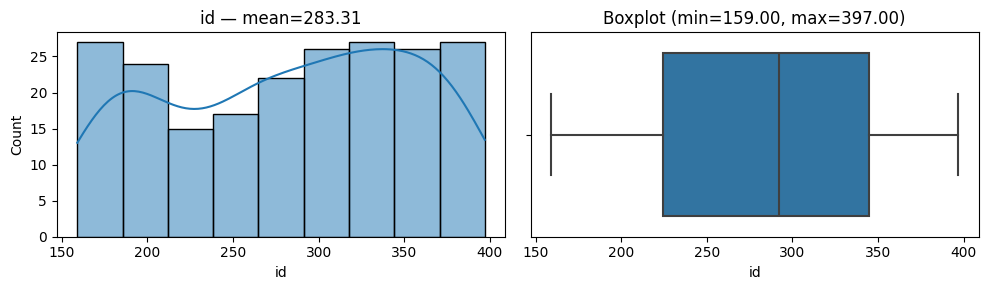

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


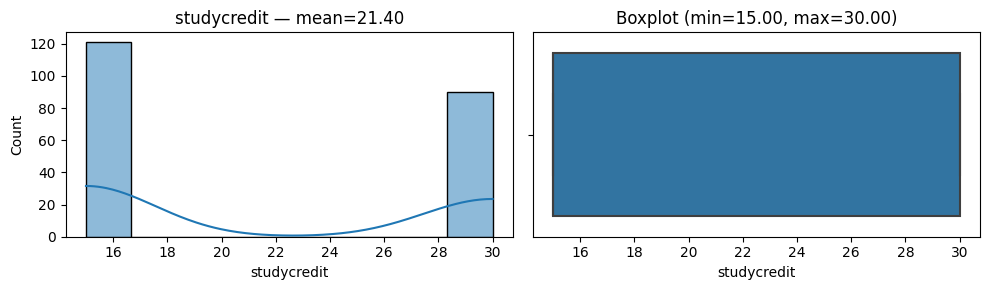

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


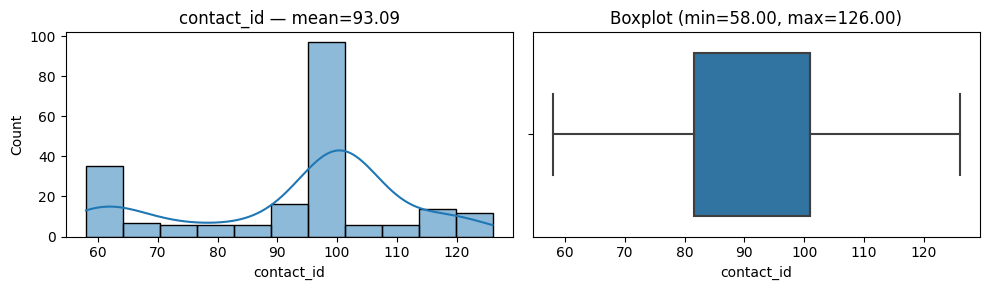

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


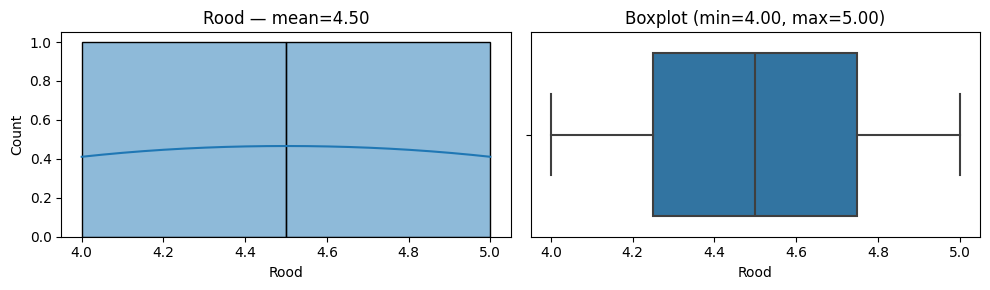

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


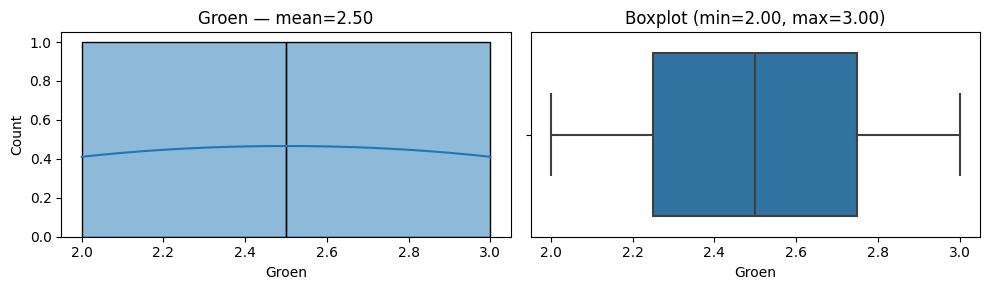

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


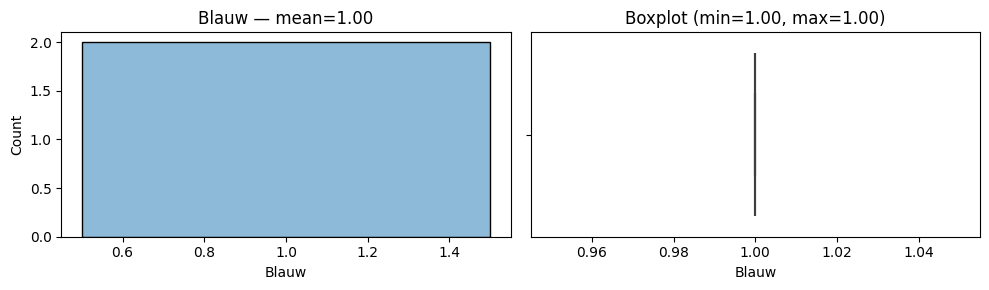

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


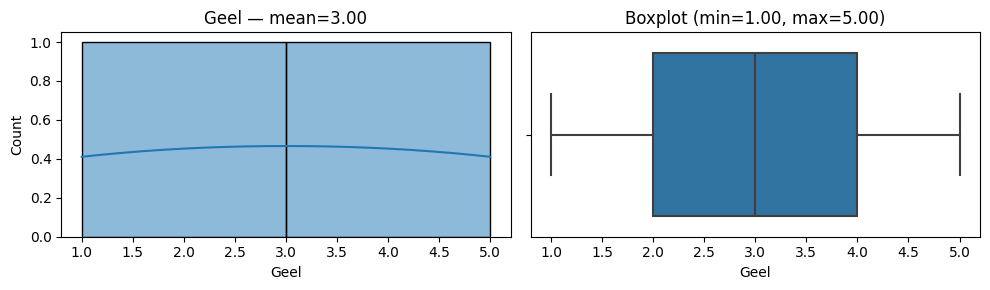

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


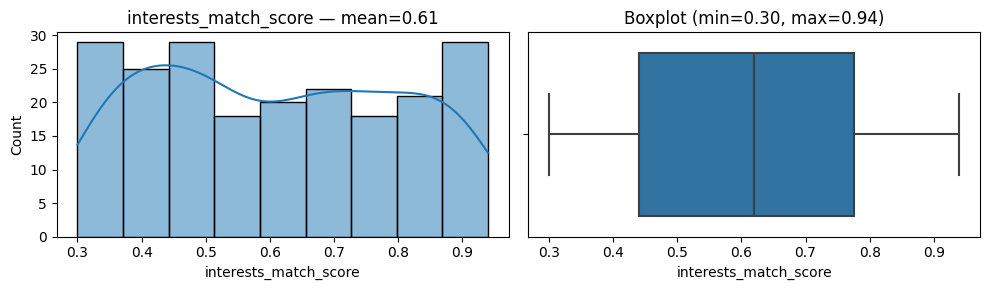

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


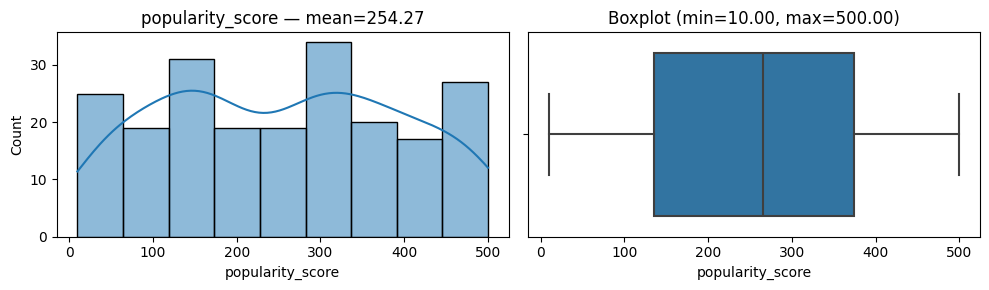

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


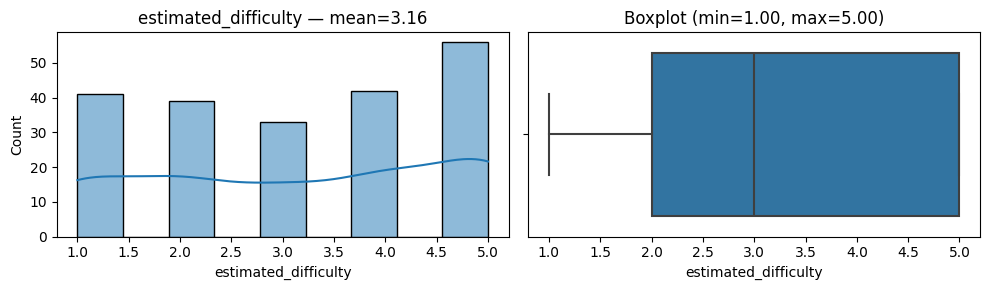

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


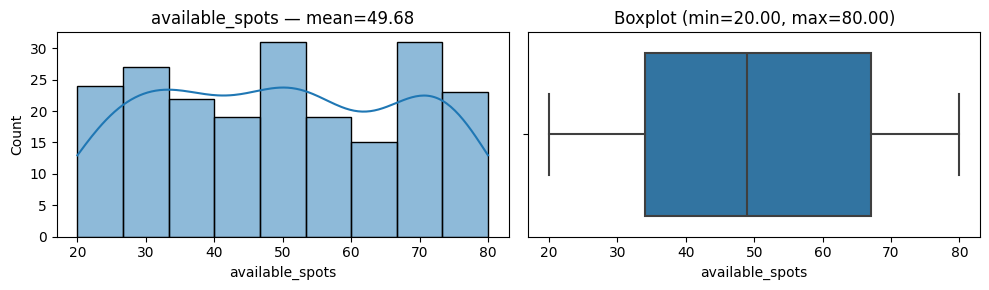

In [78]:
from IPython.display import HTML, display
import html as _html

num = df.select_dtypes(include=[np.number]).copy()
summary = []

for col in num.columns:
    col_s = num[col].dropna()
    mean = col_s.mean()
    min_val = col_s.min() if len(col_s) > 0 else np.nan
    max_val = col_s.max() if len(col_s) > 0 else np.nan

    # Plots
    if len(col_s) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.histplot(col_s, ax=axes[0], kde=True)
        axes[0].set_title(f"{col} — mean={mean:.2f}")
        sns.boxplot(x=col_s, ax=axes[1])
        axes[1].set_title(f"Boxplot (min={min_val:.2f}, max={max_val:.2f})")
        plt.tight_layout()
        plt.show()


What we found (besides the findings already mentioned earlier):
- Studycredit exists only in 15 or 30 points
- One contactId stands out for the rest 

# 5. Categorical Values

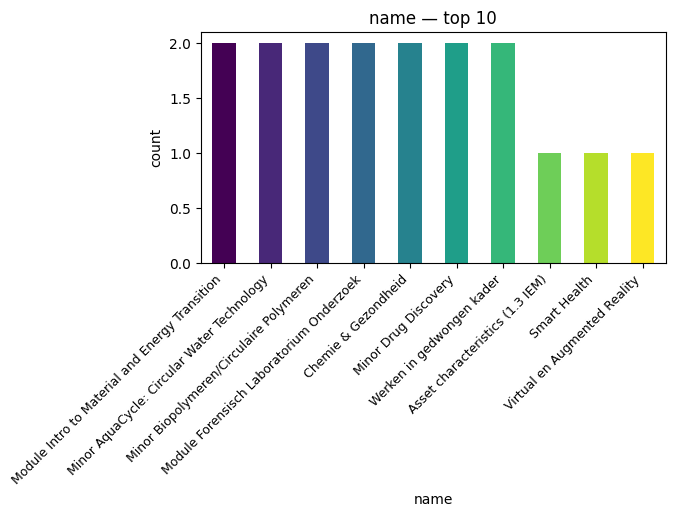

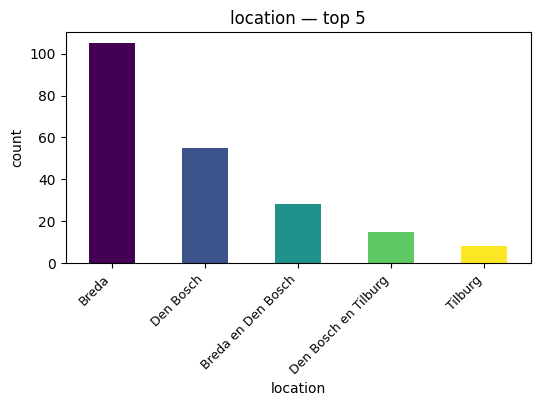

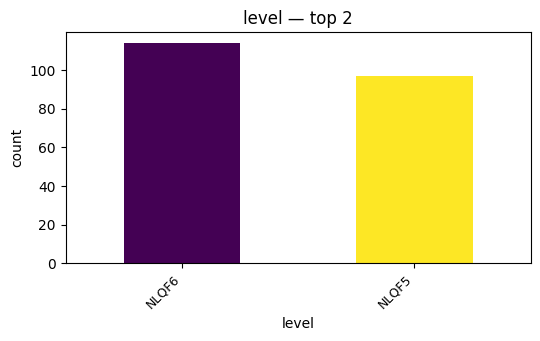

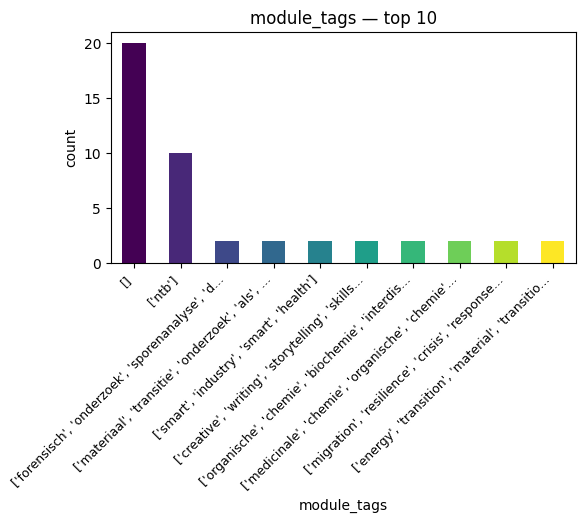

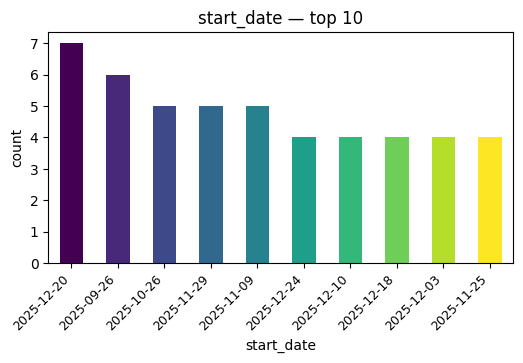

In [79]:
# top-10 (or lower if not applicable) bar charts for categorical columns

# Some categorical columns left out on purpose like shortdescription, description, etc. Not useful for bar charts. Name is used to find potential duplicates 
exclude_text_cols = ['shortdescription', 'description', 'content', 'learningoutcomes']
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in exclude_text_cols]

top_n = 10

# Shorting x-axis description otherwise too long images.
def _shorten(s, n=50):
    s = str(s)
    return s if len(s) <= n else s[:47] + '...'

for col in cat_cols:
    vc = df[col].fillna('<<NA>>').value_counts()
    top10 = vc.head(top_n)
    labels = [_shorten(x, 50) for x in top10.index]

    fig, ax = plt.subplots(figsize=(6, 3))
    colors = plt.cm.viridis(np.linspace(0, 1, len(top10)))

    top10.plot(kind='bar', color=colors, ax=ax)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_title(f'{col} — top {len(top10)}')
    ax.set_ylabel('count')
    plt.show()


What we found (besides the findings already mentioned earlier):
- Duplicates in module name found, need to be removed during data cleanup
- Some location values have 2 places mixed, better to seperate these and add them to both locations. --> making Location an array

# 6. Correlation heatmap


/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


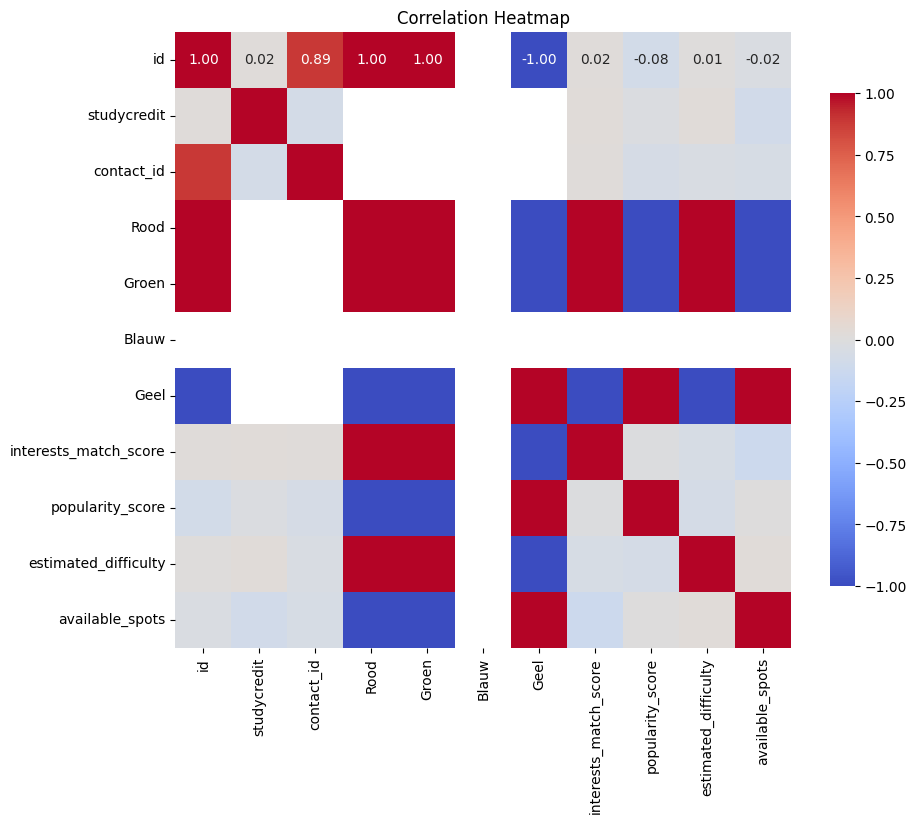

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap")
plt.show()

# 7. Text Analysis (content & description)

In [81]:
df["exact_same"] = df["content"] == df["description"]
df["exact_same"].value_counts()


exact_same
True     198
False     13
Name: count, dtype: int64

In [82]:
df.loc[~df["exact_same"], ["content", "description", "shortdescription", "module_tags"]]

,content,description,shortdescription,module_tags
19,Oncologie,Deze verdiepende module gaat in op uiteenlopende aspecten die je binnen de oncologische zorg. We zorgen voor veel inbreng vanuit de dagelijkse praktijk door inzet van gastdocenten en excursies. Na...,Ntb,['ntb']
20,Pro-active nursing,"Ontwikkel een diepgaand begrip van klinisch redeneren in onze HBO-Verpleegkunde module Pro-Active Nursing. Leer anticiperen op zorgbehoeften door doordachte analyse en gezamenlijke, eenduidige kli...",Ntb,['ntb']
21,Jongeren en actuele problematiek,"Maak impact daar waar het meest nodig is, met een focus op vroegtijdige signalering en begeleiding van jongeren met actuele problematiek. Te denken valt aan thema’s zoals mentale gezondheid, gezin...",Ntb,['ntb']
22,Management in de zorg,"Bij de keuzemodule Management in de Zorg leer je over organisatie-, personeels- en kwaliteitsmanagement in de zorgsector. Ook strategisch management, kwaliteitsmanagement en ondernemen in de zorg ...",Ntb,['ntb']
31,(product)ontwerpvraagstukken binnen zorg en welzijn.,"Deze module richt zich op (product)ontwerpvraagstukken binnen zorg en welzijn. Wil je design thinking, design sprints en maker skills leren en toepassen in ontwerpvragen in zorg en welzijn? Dan be...","zorg, welzijn, productontwerp","['zorg', 'welzijn', 'productontwerp']"
32,"Leren van kunst, niet over kunst. Door te doen, door met mensen in contact te zijn. Impact maken. Geraakt worden. Groeien als persoon en professioneel. Leren artistiek onderzoek te doen. Daar gaan...","Leren van kunst, niet over kunst. Door te doen, door met mensen in contact te zijn. Impact maken. Geraakt worden. Groeien als persoon en professioneel. Leren artistiek onderzoek te doen. Achter de...","Beeldende kunst, muziek, drama, literatuur, digitale media, persoonlijke en professionele identiteit, Art Based Learning","['beeldende', 'kunst', 'muziek', 'drama', 'literatuur', 'digitale', 'media', 'persoonlijke', 'en', 'professionele', 'identiteit', 'art', 'based', 'learning']"
35,Teaching English Abroad,"Deze internationale module bestaat uit twee delen: in het eerste deel gaan studenten van Avans en vanuit onze internationale partners, in multidisciplinaire setting aan de slag om te leren over ve...",Ntb,['ntb']
37,Het werkveld van de GGZ staat hier centraal. Deze minor is verplicht om een GGZ registratie te halen binnen profiel Zorg.,Het werkveld van de GGZ staat hier centraal. Deze minor is verplicht om een GGZ registratie te halen binnen profiel Zorg. In dit profiel gaat het o.a. om het optimaal sociaal functioneren van mens...,GGZ,['ggz']
38,De minor heeft een eigen landelijk profiel. Er wordt samengewerkt met het werkveld op basis van het landelijk curriculum.,"De minor WIGK bereidt studenten voor op het werken met mensen (volwassenen, jongeren) die grensoverschrijdend gedrag vertonen, dat schadelijk is voor hen zelf en voor hun omgeving. Probleemgedrag ...",Ntb,['ntb']
40,Acuut Complexe Zorg; verdiepende minor gericht op verpleegkunde studenten,"In de minor ACZ ga je je verdiepen in een aantal acute en complexe casussen. In deze casuïstiek staan diverse specialismen centraal. Het interessante van de minor ACZ is, dat je jezelf aan de hand...","Zorg, welzijn, acute zorg","['zorg', 'welzijn', 'acute', 'zorg']"


In [83]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Text cleaning function
# --------------------------
def normalize(text):
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return ""
    text = str(text).lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# --------------------------
# Load model
# --------------------------
print("Loading sentence transformer model...")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print("Model loaded!")

# --------------------------
# Function to compute similarity and visualize
# --------------------------
def explore_similarity(df, col1, col2, threshold=0.8):
    print("Filling NaN values...")
    df[col1] = df[col1].fillna("")
    df[col2] = df[col2].fillna("")
    
    # normalize
    print(f"Normalizing {col1} and {col2}...")
    df[f"{col1}_norm"] = df[col1].apply(normalize)
    df[f"{col2}_norm"] = df[col2].apply(normalize)

    # embeddings
    print("Computing embeddings...")
    df[f"{col1}_emb"] = df[f"{col1}_norm"].apply(lambda x: model.encode(x))
    df[f"{col2}_emb"] = df[f"{col2}_norm"].apply(lambda x: model.encode(x))

    # cosine similarity
    print("Calculating cosine similarity...")
    df["similarity"] = df.apply(
        lambda row: cosine_similarity([row[f"{col1}_emb"]], [row[f"{col2}_emb"]])[0][0],
        axis=1
    )

    # filter low similarity rows
    low_sim = df[df["similarity"] < threshold].copy()
    display_cols = [col1, col2, "similarity"]
    low_sim_display = low_sim[display_cols]

    # simple coloring function
    def highlight(val):
        if val < 0.5:
            return "background-color: red"
        elif val < 0.7:
            return "background-color: orange"
        else:
            return "background-color: yellow"

    print(f"Found {len(low_sim)} rows with similarity < {threshold}")
    return low_sim_display.style.applymap(highlight, subset=["similarity"])


Loading sentence transformer model...
Model loaded!


In [84]:
# compare content vs description
explore_similarity(df, "content", "description")

Filling NaN values...
Normalizing content and description...
Computing embeddings...
Calculating cosine similarity...
Found 11 rows with similarity < 0.8


/var/folders/35/3_3lzthn4fg231qyfx73bltr0000gn/T/ipykernel_58704/553395443.py:68: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return low_sim_display.style.applymap(highlight, subset=["similarity"])


,content,description,similarity
19,Oncologie,"Deze verdiepende module gaat in op uiteenlopende aspecten die je binnen de oncologische zorg. We zorgen voor veel inbreng vanuit de dagelijkse praktijk door inzet van gastdocenten en excursies. Na deze module heb je uitgebreide inhoudelijke kennis over oncologische ziektebeelden, kun je klinisch redeneren bij kanker. Daarnaast leer je over de psychosociale gevolgen van de ziekte en wat voor begeleiding dit vraagt van zorgvragers en hun naasten.",0.295788
20,Pro-active nursing,"Ontwikkel een diepgaand begrip van klinisch redeneren in onze HBO-Verpleegkunde module Pro-Active Nursing. Leer anticiperen op zorgbehoeften door doordachte analyse en gezamenlijke, eenduidige klinische besluitvorming. Kom tot een professionele beoordeling van hoe het gaat met de zorgvrager en maak de klinische toestand inzichtelijk.",0.474033
21,Jongeren en actuele problematiek,"Maak impact daar waar het meest nodig is, met een focus op vroegtijdige signalering en begeleiding van jongeren met actuele problematiek. Te denken valt aan thema’s zoals mentale gezondheid, gezinsproblematiek, gedrag- en houdingsaspecten en huiselijk geweld.",0.502564
22,Management in de zorg,"Bij de keuzemodule Management in de Zorg leer je over organisatie-, personeels- en kwaliteitsmanagement in de zorgsector. Ook strategisch management, kwaliteitsmanagement en ondernemen in de zorg komen aan bod. Praktische vaardigheden zoals communiceren en presenteren worden ook behandeld, evenals het bevorderen van samenwerking tussen betrokkenen, afdelingen en organisaties.",0.661321
31,(product)ontwerpvraagstukken binnen zorg en welzijn.,"Deze module richt zich op (product)ontwerpvraagstukken binnen zorg en welzijn. Wil je design thinking, design sprints en maker skills leren en toepassen in ontwerpvragen in zorg en welzijn? Dan ben je welkom bij de minor Healthcare Innovation Design! In 20 weken ontwerpen we in co-creatie met bedrijven, designers en zorg- en welzijnsinstellingen tastbare en testbare creatieve producten en diensten.",0.666844
35,Teaching English Abroad,"Deze internationale module bestaat uit twee delen: in het eerste deel gaan studenten van Avans en vanuit onze internationale partners, in multidisciplinaire setting aan de slag om te leren over verschillende schoolsytemen, curricula, didactiek, kunstvakken en een kennismakingsstage. Deel 2 staat in teken van stage lopen en praktijkonderzoek doen.",0.218834
38,De minor heeft een eigen landelijk profiel. Er wordt samengewerkt met het werkveld op basis van het landelijk curriculum.,"De minor WIGK bereidt studenten voor op het werken met mensen (volwassenen, jongeren) die grensoverschrijdend gedrag vertonen, dat schadelijk is voor hen zelf en voor hun omgeving. Probleemgedrag gaat vaak gepaard met (soms ernstige) sociale, emotionele, materiële problemen en bereikt een niveau dat justitieel ingrijpen noodzakelijk wordt.",0.550821
40,Acuut Complexe Zorg; verdiepende minor gericht op verpleegkunde studenten,"In de minor ACZ ga je je verdiepen in een aantal acute en complexe casussen. In deze casuïstiek staan diverse specialismen centraal. Het interessante van de minor ACZ is, dat je jezelf aan de hand van deze casuïstiek verdiept in de klinische zorg.",0.589977
41,"Kraam, kind en jeugdigen; verdiepende minor gericht op verpleegkunde studenten","Binnen de minor Kraam, Kind, Jeugd (KKJ) staat de zorg aan zwangeren, kraamvrouwen en kinderen van 0-18 jaar met hun ouders centraal. Het is een verdiepende minor waarin onderwerpen aan bod komen vanuit de expertisegebieden van de kinderverpleegkundige, de obstetrieverpleegkundige en de jeugdverpleegkundige. Doel van de minor is het ontwikkelen van een generieke blik op het kind en diens systeem.",0.664095
42,Positieve psychiatrie,"De minor Positieve Psychiatrie is verdiepend ten aanzien van verpleegkundige zorg aan cliënten van alle leeftijden met één of meer complexe psychiatrische aandoeningen. Uitgangpunt van de minor is specialistische 

In [85]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re

# Text cleaning function
def normalize(text):
    text = text.lower()                   # lowercase
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)      # collapse spaces
    return text.strip()

# Convert lists to clean strings
def fix_lists(x):
    if isinstance(x, list):
        # Join list elements with space and normalize
        return " ".join(map(str, x))
    if pd.isna(x) or str(x).lower() == "nan":
        return ""
    return str(x)

# Clean both columns
df["shortdescription_clean"] = df["shortdescription"].apply(fix_lists).apply(normalize)
df["module_tags_clean"] = df["module_tags"].apply(fix_lists).apply(normalize)


# Empty-check column
df["empty_mismatch"] = (
    ((df["shortdescription_clean"] == "") & (df["module_tags_clean"] != "")) |
    ((df["shortdescription_clean"] != "") & (df["module_tags_clean"] == ""))
)

print("Rows where one column is empty and the other is not:", df["empty_mismatch"].sum())

# Compute embeddings & similarity
explore_similarity(df, "shortdescription", "module_tags", threshold=0.85)


Rows where one column is empty and the other is not: 0
Filling NaN values...
Normalizing shortdescription and module_tags...
Computing embeddings...
Calculating cosine similarity...
Found 3 rows with similarity < 0.85


/var/folders/35/3_3lzthn4fg231qyfx73bltr0000gn/T/ipykernel_58704/553395443.py:68: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  return low_sim_display.style.applymap(highlight, subset=["similarity"])


,shortdescription,module_tags,similarity
74,"Bio-mimicry, tectoniek en nieuwe materialen, milieu impact, creatief ontwerpen, story telling","['biomimicry', 'tectoniek', 'en', 'nieuwe', 'materialen', 'milieu', 'impact', 'creatief', 'ontwerpen', 'story', 'telling']",0.826249
205,"ethiek, filosofie, kritisch denken, ethisch handelen in beeldende kunst en performance maar ook in (digi)taal","['ethiek', 'filosofie', 'kritisch', 'denken', 'ethisch', 'handelen', 'in', 'beeldende', 'kunst', 'en', 'performance', 'maar', 'ook', 'in', 'digitaal']",0.825760
206,"ethiek, filosofie, kritisch denken, ethisch handelen in beeldende kunst en performance maar ook in (digi)taal","['ethiek', 'filosofie', 'kritisch', 'denken', 'ethisch', 'handelen', 'in', 'beeldende', 'kunst', 'en', 'performance', 'maar', 'ook', 'in', 'digitaal']",0.825760


We analyzed the similarity between different text columns in the dataset, focusing on content versus description and shortdescription versus module_tags. When we compared content and description, we found 11 rows with a cosine similarity below 0.8, which showed me that some module content didn’t really reflect their full descriptions. The lowest similarities were for modules like Oncologie (0.296) and Teaching English Abroad (0.219), which told me the titles were quite different from the content. For shortdescription versus module_tags, we noticed 6 rows with similarity below 0.88, which made me realize that some short descriptions or tags didn’t fully match the modules. Overall, most rows had decent similarity, but a few stood out as needing attention, so we know where we might want to refine or standardize the data.

## Additional Findings

- The dataset contains essentially no meaningful numerical relationships internally.  
- The high correlation between `ID` and `Contact-ID` can be ignored, as it has no practical significance.  
- Color values are not useful and can be disregarded.  
- **Shortdescription vs. module_tags similarity**  
  - Most rows show high similarity.  
  - A few outliers indicate where refinement or standardization may be needed.  
  - Not all modules have `shortdescription` filled in, so this field will likely be dropped during data cleaning.  
- **Content vs. description similarity**  
  - Most rows show high similarity, with some outliers needing review.  
  - Specific modules may require refinement of `content` or `description`.  
  - Ultimately, the `content` field will likely be dropped as it is inconsistently filled.


# 7. Thoughts for final model
Based on our exploration of the dataset, we cannot build a traditional prediction (classification) model. The available features show no significant correlations with the target variable (title or id), making it impossible to predict using standard methods. This is further complicated by the fact that most of the data is text. Additionally, the target itself represents content, which is not easily predicted using standard regression or classification techniques.

Because of this, a recommendation system is a much more suitable solution. Instead of predicting a specific value, a recommender focuses on similarity between items or user preferences, which matches the structure of our dataset.

Therefore, we will proceed with building a Content-Based Recommender system, which leverages the textual features of the dataset to recommend similar items based on their content. We will utilize techniques such as TF-IDF vectorization, embedding, and cosine similarity to measure the similarity between user profiles and the items in the dataset. This approach allows us to provide personalized recommendations without relying on traditional predictive modeling.

But first, we are going to clean the dataset. This is done in the next notebook.